In [26]:
import pandas as pd
import numpy as np
from subprocess import call
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import pairwise_distances
from surprise import SVD, Dataset, Reader
from scipy import stats
import multiprocessing as mp
from scipy.linalg import cho_factor, cho_solve


rating = pd.read_csv("u.data", sep="\t", names = ['user_id', 'item_id', 'rating', 'timestamp'])
rating

user_id  item_id  rating  timestamp
0          196      242       3  881250949
1          186      302       3  891717742
2           22      377       1  878887116
3          244       51       2  880606923
4          166      346       1  886397596
...        ...      ...     ...        ...
99995      880      476       3  880175444
99996      716      204       5  879795543
99997      276     1090       1  874795795
99998       13      225       2  882399156
99999       12      203       3  879959583

[100000 rows x 4 columns]

In [2]:
rating_matrix1 = rating.pivot_table(index = ['user_id'], columns = ['item_id'], values = ['rating'])
rating_matrix1

rating_matrix = rating_matrix1.dropna(thresh = 10, axis = 1)
rating_matrix = rating_matrix.fillna(0)



'''rating_matrix = rating_matrix.dropna(thresh = 10, axis = 0)
sum(list(rating_matrix.isna().astype(int).sum(axis = 0)))

n_users = rating_matrix.shape[0]
n_movies = rating_matrix.shape[1]
print(n_users, n_movies)
rating_matrix'''
rating_matrix

rating                                               ...            \
item_id   1    2    3    4    5    6    7    8    9    10    ... 1446 1451   
user_id                                                      ...             
1          5.0  3.0  4.0  3.0  3.0  5.0  4.0  1.0  5.0  3.0  ...  0.0  0.0   
2          4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  0.0  0.0   
3          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5          4.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
939        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  0.0  0.0   
940        0.0  0.0  0.0  2.0  0.0  0.0  4.0  5.0  3.0  0.0  ...  0.0  0.0   
941        5.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  ...  0.0  0.0   
942        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
943        0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0  ...  0.0  0.0   

                                                 
item_id 1469 1478 1480 1483 1503 1518 1540 1615  
user_id                                          
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...      ...  ...  ...  ...  ...  ...  ...  ...  
939      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
940      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
941      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
942      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
943      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[943 rows x 1152 columns]

In [3]:
n_users = rating['user_id'].nunique()
n_movies = rating['item_id'].nunique()
Ratings = np.array(rating_matrix)
r = pd.DataFrame(Ratings)
total_possibilities = np.prod(Ratings.shape)
user_activity = np.flatnonzero(Ratings).shape[0]
total_sparsity = 100 * (user_activity / total_possibilities)
print("{}%".format(total_sparsity))
r

9.016823524213503%


0     1     2     3     4     5     6     7     8     9     ...  1142  \
0     5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   0.0   
1     4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...   0.0   
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4     4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
938   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   5.0   0.0  ...   0.0   
939   0.0   0.0   0.0   2.0   0.0   0.0   4.0   5.0   3.0   0.0  ...   0.0   
940   5.0   0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0  ...   0.0   
941   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
942   0.0   5.0   0.0   0.0   0.0   0.0   0.0   0.0   3.0   0.0  ...   0.0   

     1143  1144  1145  1146  1147  1148  1149  1150  1151  
0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
938   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
939   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
940   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
941   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
942   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[943 rows x 1152 columns]

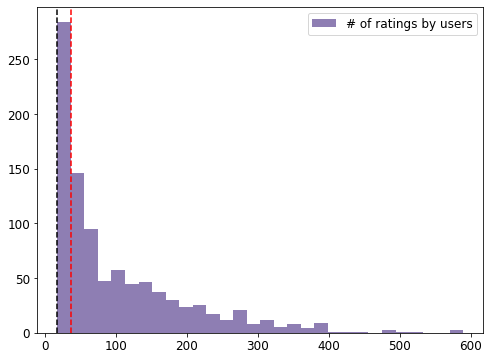

In [4]:
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

plt.hist(np.sum(Ratings != 0, axis = 1), histtype = 'stepfilled', bins = 30,
         alpha = 0.85, label = '# of ratings by users', color = '#7A68A6')
plt.axvline(x = 18, color = 'black', linestyle = '--')
plt.axvline(x = 37, color = 'red', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()

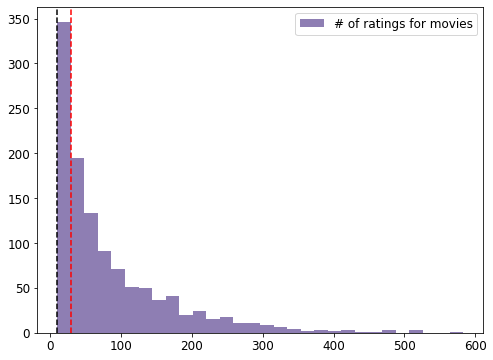

10

In [5]:
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

plt.hist(np.sum(Ratings != 0, axis = 0), histtype = 'stepfilled', bins = 30,
         alpha = 0.85, label = '# of ratings for movies', color = '#7A68A6')
plt.axvline(x = 10, color = 'black', linestyle = '--')
plt.axvline(x = 29, color = 'red', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()

list(np.sum(Ratings != 0, axis=0))[17]

In [6]:
rating["status"] = [1]*rating.shape[0]
Pre_use_preferences1 = rating.pivot_table(index = ['user_id'], columns = ['item_id'], values = ["status"])
Pre_use_preferences1

Pre_use_preferences = Pre_use_preferences1.dropna(thresh = 10, axis = 1)
'''sum(list(Pre_use_preferences.isna().astype(int).sum(axis=1)))'''

Pre_use_preferences = Pre_use_preferences.fillna(0)
Pre_use_preferences

status                                               ...            \
item_id   1    2    3    4    5    6    7    8    9    10    ... 1446 1451   
user_id                                                      ...             
1          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0   
2          1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0   
3          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5          1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
939        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   
940        0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  ...  0.0  0.0   
941        1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0   
942        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
943        0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   

                                                 
item_id 1469 1478 1480 1483 1503 1518 1540 1615  
user_id                                          
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...      ...  ...  ...  ...  ...  ...  ...  ...  
939      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
940      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
941      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
942      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
943      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[943 rows x 1152 columns]

In [7]:
'''Pre_use_preferences_similarities = 1 - pairwise_distances(Pre_use_preferences, metric="cosine")
Pre_use_preferences_similarities'''

'''def percentile(arr):
    arr = list(arr)
    l = len(arr)
    ptile = []
    Sort_arr = sorted(arr)
    for i in arr:
        ptile.append(arr.index(i)/l)
    
    return ptile

Percentile_matrix = []
for i in range(len(Pre_use_preferences_predictions)):
    Percentile_matrix.append(percentile(Pre_use_preferences_predictions[0]))

#for N neighbours
q = list((Pre_use_preferences != 0).astype(int).sum(axis=0))
def nearestNeighbours(user, N=300):
    neighbours = []
    weights = []
    a = pd.DataFrame(Pre_use_preferences.iloc[:, m])
    a = list(a.index[a.iloc[:, 0] != 0])
    c = [Pre_use_preferences_similarities[user][i-1] for i in a]
    arr = list(Pre_use_preferences_similarities[user])
    for i in range(0, N+1):
        p = max(arr)
        q = arr.index(p)
        neighbours.append(q)
        weights.append(p)
        arr[q] = -1
    for i in range(0, N):
        p = max(c)
        q = c.index(p)
        neighbours.append(a[q])
        weights.append(p)
        a[q] = -1
        c[q] = -1
    return neighbours[1:], weights[1:]

a, b = nearestNeighbours(2)

print(a, b)

def filtering():
    p_arr = np.array(Pre_use_preferences)
    for i in range(0, Pre_use_preferences.shape[0]):
        for j in range(0, Pre_use_preferences.shape[1]):
            if p_arr[i][j] == 0:
                numerator = []
                ind, wt = nearestNeighbours(i)
                numerator = [(p_arr[ind[k]-1][j])*float(wt[k]) for k in range(0, len(wt))]
                p_arr[i][j] = sum(numerator)/sum(wt)
    return p_arr

ans = filtering()
ans'''

'def percentile(arr):\n    arr = list(arr)\n    l = len(arr)\n    ptile = []\n    Sort_arr = sorted(arr)\n    for i in arr:\n        ptile.append(arr.index(i)/l)\n    \n    return ptile\n\nPercentile_matrix = []\nfor i in range(len(Pre_use_preferences_predictions)):\n    Percentile_matrix.append(percentile(Pre_use_preferences_predictions[0]))\n\n#for N neighbours\nq = list((Pre_use_preferences != 0).astype(int).sum(axis=0))\ndef nearestNeighbours(user, N=300):\n    neighbours = []\n    weights = []\n    a = pd.DataFrame(Pre_use_preferences.iloc[:, m])\n    a = list(a.index[a.iloc[:, 0] != 0])\n    c = [Pre_use_preferences_similarities[user][i-1] for i in a]\n    arr = list(Pre_use_preferences_similarities[user])\n    for i in range(0, N+1):\n        p = max(arr)\n        q = arr.index(p)\n        neighbours.append(q)\n        weights.append(p)\n        arr[q] = -1\n    for i in range(0, N):\n        p = max(c)\n        q = c.index(p)\n        neighbours.append(a[q])\n        weights.ap

In [8]:
Pre_use = np.array(Pre_use_preferences)
Pre_use

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [9]:
#Creating Training and tesing sets
def split_train_test(r):
    test_set = np.zeros(r.shape)
    train_set = r.copy()
    for i in range(r.shape[0]):
        test_indices = np.random.choice(np.flatnonzero(r[i]), size = 10, replace = False)
        
    train_set[i, test_indices] = 0.0
    test_set[i, test_indices] = r[i, test_indices]
    
    return train_set, test_set

In [12]:
alpha = 40
C = 1 + alpha*Ratings
C

array([[201., 121., 161., ...,   1.,   1.,   1.],
       [161.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       ...,
       [201.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1., 201.,   1., ...,   1.,   1.,   1.]])

In [25]:
a = np.zeros((Ratings.shape[0], Ratings.shape[1]))
a[:, 0] = Ratings[:, 0]
q = np.zeros((943, ))
q = a.T[0]
q

array([5., 4., 0., 0., 4., 4., 0., 0., 0., 4., 0., 0., 3., 0., 1., 5., 4.,
       5., 0., 3., 5., 0., 5., 0., 5., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 5., 0., 0., 4., 5., 5., 4., 5., 0., 0., 0., 2., 0., 0.,
       0., 0., 4., 0., 4., 5., 5., 2., 0., 0., 2., 3., 4., 3., 3., 3., 0.,
       0., 4., 0., 4., 2., 0., 4., 0., 5., 0., 4., 0., 4., 4., 4., 2., 0.,
       0., 0., 0., 5., 0., 0., 4., 5., 4., 5., 5., 4., 0., 4., 0., 3., 3.,
       0., 0., 0., 4., 0., 4., 4., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0.,
       4., 4., 0., 0., 3., 4., 0., 0., 4., 0., 5., 4., 0., 0., 5., 0., 0.,
       3., 4., 0., 0., 3., 0., 0., 4., 3., 0., 0., 4., 0., 4., 5., 0., 0.,
       0., 0., 0., 5., 4., 0., 4., 0., 4., 0., 0., 0., 0., 0., 5., 0., 0.,
       0., 0., 0., 3., 0., 0., 3., 4., 0., 0., 3., 4., 0., 4., 0., 0., 0.,
       0., 5., 0., 0., 0., 4., 4., 0., 0., 0., 4., 1., 5., 3., 3., 3., 2.,
       0., 0., 0., 0., 5., 5., 0., 0., 2., 0., 0., 4., 0., 0., 0., 0., 0.,
       4., 4., 0., 0., 0.

In [122]:
class Pre_use_Predictions:
    def __init__(self, iters, reg_param, num_features):
        self.iters = iters
        self.reg = reg_param
        self.n_features = num_features
        
    def core_function(self, ru, Y, Z, alpha):
        b = 0
        j = 0
        K = list(np.where(ru > 0)[0])
        V = np.zeros((Y.shape[0], len(K)))
        W = np.zeros((Y.shape[0], len(K)))
        print(Y.shape)
        print(Y[:,1].shape)
        for i in K:
            V[:, j] = Y[:, i]*ru[i]
            W[:, j] = Y[:, j]
            b = (1 + alpha*(ru[i]))*Y[:, i]
            j = j + 1
        print(Z.shape, V.shape, W.shape)
        A = Z + alpha*(np.dot(V, W.T)) + self.reg*(np.eye(Y.shape[0]))
        c, low = cho_factor(A)
        x = cho_solve((c, low), b)
        return x
        
        
    def wALS(self, R, X, Y, alpha):
        #gradient descent of the Objective Function used in Alternating Least Squares
        '''op = R.dot(y)
        M = y.T.dot(y) + (np.eye(self.n_features)*self.reg)
        Minv = np.linalg.inv(M)
        x = op.dot(Minv)
        return x'''
    
        '''if token == 1:
            for user in range(R.shape[0]):
                Wu = np.diag(Q[user])
                a = (R[user].dot(Wu)).dot(y)
                Ainv = np.linalg.inv((y.T.dot(Wu)).dot(y) + np.eye(self.n_features)*(self.reg*user_wts[user]))
                x[user] = a.dot(Ainv)
            return x
                
        elif token == 0:    
            for item in range(R.shape[1]):
                Wi = np.diag(Q[:, item])
                a = (R[:, item].T.dot(Wi)).dot(x)
                Ainv = np.linalg.inv(((x.T.dot(Wi)).dot(x)) + (np.eye(self.n_features)*(self.reg*item_wts[item])))
                y[item] = a.dot(Ainv)
            return y'''
        Z = np.dot(Y, Y.T)
        for u in range(X.shape[1]):
            X[u] = self.core_function(R[u], Y, Z, alpha)
        
        Z = np.dot(X, X.T)
        for i in range(len(Y.shape[1].shape)):
            Y[u] = self.core_function(R[:, i], X, Z, alpha)
        
        return X, Y
    
    def prediction(self):
        pred = self.X.dot(self.Y.T)
        return pred
    
    def calc_mse(self, M, M2):
        indices = np.nonzero(M)
        mse = mean_squared_error(M[indices], M2[indices])
        return mse
    
    def train_model(self, train, test):
        self.n_user , self.n_movies = train.shape
        
        #initialization of user and item matrices before model is trained 
        self.X = np.random.rand(self.n_features, self.n_user)
        self.Y = np.random.rand(self.n_features, self.n_movies)
        
        self.test_mse = []
        self.train_mse = []
        pool = mp.Pool(mp.cpu_count())
        
        for q in range(self.iters):
            self.X, self.Y = self.wALS(train, self.X, self.Y, 40)
            p = self.prediction()
            self.test_mse.append(self.calc_mse(test, p))
            self.train_mse.append(self.calc_mse(train, p))
            
        return p
    @staticmethod
    def plot_learning_curve(model):
        linewidth = 3
        plt.plot(model.test_mse, label = 'Test', linewidth = linewidth)
        plt.plot(model.train_mse, label = 'Train', linewidth = linewidth)
        plt.xlabel('num of iterations')
        plt.ylabel('MSE val')
        plt.legend(loc = 'best')
            
            



In [123]:
training_set, test_set = split_train_test(Ratings)
filtering = Pre_use_Predictions(2, 0.01, 30)
filtering.train_model(training_set, test_set)

(30, 1152)
(30,)
(30, 30) (30, 263) (30, 263)


ValueError: could not broadcast input array from shape (30) into shape (943)

In [13]:
def cv_train_test(r):
    test_set = np.zeros(r.shape)
    train_set = r.copy()
    for i in range(r.shape[0]):
        test_indices = np.random.choice(np.flatnonzero(r[i]), size = 10, replace = False)
        
    train_set[i, test_indices] = 0.0
    test_set[i, test_indices] = r[i, test_indices]
    
    return train_set, test_set

In [27]:
'''alpha = [0.001, 0.01, 0.02]
features = [5, 10, 18, 25, 30, 35]
params = []
its_train = []
its_test = []

for i in alpha:
    for j in features:
        cycle_outcomes_train = []
        cycle_outcomes_test = []
        for cycles in range(10):
            training_set, test_set  = cv_train_test(Pre_use)
            filtering = Pre_use_Predictions(iters = 40, num_features = j, reg_param=i)
            P_hat = filtering.train_model(training_set, test_set)
            cycle_outcomes_train.append(filtering.train_mse[:])
            cycle_outcomes_test.append(filtering.test_mse[:])
        its_train.append(np.sum(np.array(cycle_outcomes_train), axis = 0)/10)
        its_test.append(np.sum(np.array(cycle_outcomes_test), axis = 0)/10)
        params.append([40, j, i])
        #its_train.append(filtering.train_mse)
        #its_test.append(filtering.test_mse)'''
        
'''for i in [10, 20, 30, 40]:
    cycle_outcomes_train = []
    cycle_outcomes_test = []
    for cycles in range(10):
        training_set, test_set  = cv_train_test(Pre_use)
        filtering = Pre_use_Predictions(iters = i, num_features = 30, reg_param=0.001)
        P_hat = filtering.train_model(training_set, test_set)
        cycle_outcomes_train.append(filtering.train_mse[:])
        cycle_outcomes_test.append(filtering.test_mse[:])
    its_train.append(np.sum(np.array(cycle_outcomes_train), axis = 0)/10)
    its_test.append(np.sum(np.array(cycle_outcomes_test), axis = 0)/10)
    params.append([i, 30, 0.001])
    #its_train.append(filtering.train_mse)
    #its_test.append(filtering.test_mse)'''


def Cross_Validation_Build(iters, features, reg, k = 10):
    its_train = []
    its_test = []
    cycle_outcomes_train = []
    cycle_outcomes_test = []
    for cycles in range(k):
        training_set, test_set  = cv_train_test(Pre_use)
        filtering = Pre_use_Predictions(iters = 20, num_features = 30, reg_param=0.001)
        P_hat = filtering.train_model(training_set, test_set)
        cycle_outcomes_train.append(filtering.train_mse[:])
        cycle_outcomes_test.append(filtering.test_mse[:])
    its_train.append(np.sum(np.array(cycle_outcomes_train), axis = 0)/10)
    its_test.append(np.sum(np.array(cycle_outcomes_test), axis = 0)/10)
    return P_hat, its_train, its_test
        #its_train.append(filtering.train_mse)
        #its_test.append(filtering.test_mse)



In [14]:
print(its_train, its_test)
len(its_train)

NameError: name 'its_train' is not defined

In [15]:
indu = 0
print(params)
print(min(its_test[0]))
print(list(its_test[0]).index(min(its_test[0])))

linewidth = 2
plt.plot(its_test[0], label = 'Test', linewidth = linewidth)
plt.plot(its_train[0], label = 'Train', linewidth = linewidth)
plt.xlabel('num of iterations')
plt.ylabel('MSE val')
plt.legend(loc = 'best')


NameError: name 'params' is not defined

In [28]:
training_set, test_set = split_train_test(Pre_use)

P_hat, train_errs, test_errs = Cross_Validation_Build(k = 10, iters = 6, features = 30, reg = 0.001)

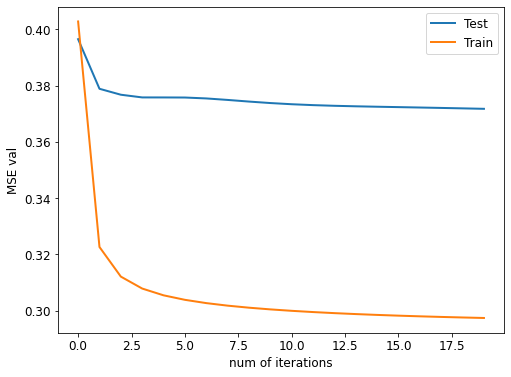

In [36]:
linewidth = 2
plt.plot(test_errs[0], label = 'Test', linewidth = linewidth)
plt.plot(train_errs[0], label = 'Train', linewidth = linewidth)
plt.xlabel('num of iterations')
plt.ylabel('MSE val')
plt.legend(loc = 'best')


In [37]:
min(train_errs[0])

0.2973677611392215

In [38]:
for i in range(Pre_use.shape[0]):
    for j in range(Pre_use.shape[1]):
        if Pre_use[i][j] == 1:
            P_hat[i][j] = Pre_use[i][j]
            
P_hat

array([[ 1.        ,  1.        ,  1.        , ...,  0.40311531,
         1.07716337,  0.62078196],
       [ 1.        ,  0.11612998,  0.06845241, ...,  0.43739772,
        -0.05251442,  0.3857085 ],
       [ 0.09803304, -0.08362847,  0.02349628, ...,  0.43270753,
         0.22629105,  0.46163878],
       ...,
       [ 1.        ,  0.02334311,  0.1017464 , ..., -0.00618088,
        -0.12827494,  0.45056398],
       [ 0.206955  ,  0.10286764, -0.12178197, ..., -0.44062407,
         0.53651466,  0.06293834],
       [ 0.51659234,  1.        ,  0.14448889, ...,  0.1293922 ,
         0.75710093, -0.20299493]])

In [86]:
pd.DataFrame(P_hat).to_csv("Pre_use_Predictions.csv")

In [127]:
ffff = np.sum(P_hat[392])/1152 + np.min(P_hat[392])
np.sum(P_hat[392])/1152, np.min(P_hat[392]), ffff


(0.435589080218917, -1.4660009797964806, -1.0304118995775635)

In [169]:
theta = 50
for i in range(Ratings.shape[0]):
    low = np.percentile(P_hat[i], theta)
    vui = np.sum(Ratings[i])/np.sum(Ratings[i] != 0)
    for j in range(Ratings.shape[1]):
        if P_hat[i][j] <= low:
            delta = (stats.percentileofscore(P_hat[i], P_hat[i][j], 'rank') * 1.5)/100
            Ratings[i][j] = vui*delta

    

In [176]:
pd.DataFrame(Ratings).to_csv("Augmented_Matrix.csv")

In [12]:
Aug_df = pd.read_csv("Augmented_Matrix.csv")
Aug_df.drop('Unnamed: 0', inplace=True, axis=1)
Aug_df

0         1         2         3         4         5         6  \
0    5.0  3.000000  4.000000  3.000000  3.000000  5.000000  4.000000   
1    4.0  0.000000  0.000000  0.000000  1.152561  0.000000  0.000000   
2    0.0  0.265794  1.631173  0.393229  0.000000  1.696711  0.000000   
3    0.0  1.805556  2.713976  3.097656  0.000000  2.104601  0.000000   
4    4.0  3.000000  0.631757  0.000000  2.039024  0.495570  0.000000   
..   ...       ...       ...       ...       ...       ...       ...   
938  0.0  1.982701  0.000000  0.272135  0.000000  0.738653  0.000000   
939  0.0  0.634857  0.738415  2.000000  0.000000  2.525920  4.000000   
940  5.0  0.000000  0.000000  0.221236  0.000000  2.064867  4.000000   
941  0.0  0.000000  0.266614  1.710773  1.122000  0.000000  2.438407   
942  0.0  5.000000  0.000000  0.000000  0.000000  1.284384  0.000000   

            7         8         9  ...      1142      1143      1144  \
0    1.000000  5.000000  3.000000  ...  0.037904  0.033166  0.000000   
1    1.162370  0.000000  2.000000  ...  0.000000  0.696441  1.638108   
2    0.000000  0.000000  1.212457  ...  0.000000  0.000000  0.000000   
3    0.919705  0.530382  2.251302  ...  0.000000  0.000000  1.670139   
4    0.000000  0.090791  0.000000  ...  0.000000  0.964659  0.000000   
..        ...       ...       ...  ...       ...       ...       ...   
938  0.000000  5.000000  0.605362  ...  0.000000  0.005554  0.000000   
939  5.000000  3.000000  0.000000  ...  0.000000  0.000000  0.963542   
940  0.000000  0.000000  2.038530  ...  0.000000  0.711115  1.211529   
941  0.000000  1.910733  2.571713  ...  0.316604  0.000000  2.132911   
942  0.000000  3.000000  0.328874  ...  0.666635  1.568815  0.000000   

         1145      1146      1147      1148      1149      1150      1151  
0    2.539567  0.056856  0.004738  1.312426  0.658582  0.000000  1.776750  
1    0.000000  0.745486  0.000000  0.000000  0.000000  0.814149  0.000000  
2    0.000000  1.816864  0.000000  0.000000  0.000000  0.000000  0.000000  
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4    0.052962  0.000000  0.000000  0.000000  0.003783  0.000000  0.000000  
..        ...       ...       ...       ...       ...       ...       ...  
938  0.672008  0.000000  2.310374  2.860199  0.000000  0.000000  0.000000  
939  0.000000  0.000000  0.000000  0.000000  2.566443  0.000000  0.661872  
940  0.000000  0.142223  0.000000  0.316051  2.507339  0.021070  0.000000  
941  2.449515  0.000000  0.000000  0.000000  0.005554  0.000000  0.000000  
942  0.000000  0.000000  2.533215  1.857691  0.000000  0.000000  0.071108  

[943 rows x 1152 columns]

In [72]:
test = np.array(Aug_df)
users = []
items = []
stars = []
for i in range(Aug_df.shape[0]):
    a = np.where(test[i] > 0)[0]
    stars.extend(np.take(test[i], a))
    items.extend(list(a))
    U = [i+1]*len(a)
    users.extend(U)
len(users), len(items), len(stars)

(641069, 641069, 641069)

In [77]:
star_dict= {'userID':users,
            'itemsID':items,
            'ratings':stars
            }
Ratings_for_Svd=pd.DataFrame(star_dict)
Ratings_for_Svd

userID  itemsID   ratings
0            1        0  5.000000
1            1        1  3.000000
2            1        2  4.000000
3            1        3  3.000000
4            1        4  3.000000
...        ...      ...       ...
641064     943     1142  0.666635
641065     943     1143  1.568815
641066     943     1147  2.533215
641067     943     1148  1.857691
641068     943     1151  0.071108

[641069 rows x 3 columns]

In [84]:
reader=Reader(rating_scale=(0,5))
Svd_data=Dataset.load_from_df(Ratings_for_Svd[['userID','itemsID','ratings']],reader)

(None, None)

In [87]:
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [86]:
data = Svd_data

algo = SVD()

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv = 5, verbose = True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5902  0.5885  0.5902  0.5893  0.5875  0.5891  0.0010  
MAE (testset)     0.4395  0.4375  0.4390  0.4382  0.4369  0.4382  0.0010  
Fit time          87.43   89.53   37.34   34.68   34.51   56.70   25.98   
Test time         5.37    2.02    1.58    2.59    1.55    2.62    1.42    


{'test_rmse': array([0.59016401, 0.58851956, 0.59019533, 0.5892548 , 0.58752618]),
 'test_mae': array([0.43947687, 0.43754189, 0.43902356, 0.43815075, 0.43686417]),
 'fit_time': (87.42869567871094,
  89.53420519828796,
  37.34311866760254,
  34.67953276634216,
  34.508652687072754),
 'test_time': (5.36834979057312,
  2.0158095359802246,
  1.583824634552002,
  2.5893466472625732,
  1.547248363494873)}

In [89]:
param_grid = {'n_epochs': [5, 10, 20, 30, 40, 50, 100], 'lr_all': [0.002, 0.005, 0.001, 0.01],
              'reg_all': [0.4, 0.6, 0.2, 0.1, 0.01]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.5896449755280688
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.01}
